In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from numba import njit,jit,prange,set_num_threads
import time
import evtk

In [6]:
# grid generation
delX = 0.2
delY = 0.04
x_max = 20
y_max = 2
x_grid = np.arange(0,x_max+delX,delX)
y_grid = np.arange(0,y_max+delY,delY)
Nx = len(x_grid)
Ny = len(y_grid)

grid_spacing = min(delX,delY)

beta = delX/delY
maxCo = 0.5
delT = maxCo * grid_spacing/1.5
Re = 200

In [7]:
def parabolic_vel_profile(y_tilda):
    temp = (y_tilda - 1.5)**2
    u_tilda = 1.5 - 6*temp
    return u_tilda

In [8]:
def func_uStar(u_old,v_old):
    u_Star = np.copy(u_old)
    for j in range(0,Ny-1): #All the nodal values need to be estimated
        for i in range(0,Nx-2): #Two boundary nodes are removed [control volume is written for uP = u[j,i+1]]
            uE = u_old[j,i+2]
            uP = u_old[j,i+1]
            uW = u_old[j,i]
            if(j!=0):
                uS = u_old[j-1,i+1]
            else:
                uS = 0 #vs will be zero due to no slip. So no need to calculate uS explicitly. dudy_s is sufficient
            if(j!=Ny-2):
                uN = u_old[j+1,i+1]
            else:
                uN=0 #vn will be zero due to no slip. Hence dudy_n is sufficient
            uw = 0.5*(uW+uP)
            ue = 0.5*(uP+uE)

            vn = 0.5*(v_old[j+1,i]+v_old[j+1,i+1])
            vs = 0.5*(v_old[j,i]+v_old[j,i+1])

            dudx_e = (uE-uP)/delX
            dudx_w = (uP-uW)/delX
            
            if(j!=0):
                dudy_s = (uP-uS)/delY
            else:
                dudy_s = (9*uP - uN)/(3*delY)
                
            if(j!=Ny-2):
                dudy_n = (uN-uP)/delY
            else:
                dudy_n = (uS-9*uP)/(3*delY)
            

            #Upwinding the convection term to make the scheme stable. CS is not a stable scheme for convection
            uw_uw = 0.5*(np.abs(uw)+uw)*uW - 0.5*(np.abs(uw)-uw)*uP
            ue_ue = 0.5*(np.abs(ue)+ue)*uP - 0.5*(np.abs(ue)-ue)*uE

            us_vs = 0.5*(np.abs(vs)+vs)*uS - 0.5*(np.abs(vs)-vs)*uP
            un_vn = 0.5*(np.abs(vn)+vn)*uP - 0.5*(np.abs(vn)-vn)*uN

            #Assembling all together
            term_1 = (uw_uw-ue_ue)/delX
            term_2 = (us_vs - un_vn)/delY
            term_3 = (dudx_e-dudx_w)/delX
            term_4 = (dudy_n-dudy_s)/delY

            Ru = term_1 + term_2 + (term_3 + term_4)/Re
            u_Star[j,i+1] = u_old[j,i+1] + delT*Ru #delT is the relaxation factor for updation
    return u_Star

In [9]:
def func_vStar(u_old,v_old):
    v_Star = np.copy(v_old)
    for j in range(0,Ny-2):
        for i in range(0,Nx-1):
            vP = v_old[j+1,i]
            vN = v_old[j+2,i]
            vS = v_old[j,i]
            
            if(i!=0):
                vW = v_old[j+1,i-1]
            else: #uw will be zero and the flow at inlet is uni-directional. So vW is zero
                vW = 0
            
            if(i!=Nx-2):
                vE = v_old[j+1,i+1]
            else:
                vE = vP
            
            uw = 0.5*(u_old[j+1,i]+u_old[j,i])
            ue = 0.5*(u_old[j+1,i+1]+u_old[j,i+1])
            
            vn = 0.5*(vN+vP)
            vs = 0.5*(vP+vS)
            
            #upwinding for convective flux to achieve satbility
            uw_vw = 0.5*(np.abs(uw)+uw)*vW - 0.5*(np.abs(uw)-uw)*vP
            ue_ve = 0.5*(np.abs(ue)+ue)*vP - 0.5*(np.abs(ue)-ue)*vE
            
            vs_vs = 0.5*(np.abs(vs)+vs)*vS - 0.5*(np.abs(vs)-vs)*vP
            vn_vn = 0.5*(np.abs(vn)+vn)*vP - 0.5*(np.abs(vn)-vn)*vN
            
            #diffusive fluxes
            dvdx_e = (vE-vP)/delX
            dvdx_w = (vP-vW)/delX
            dvdy_n = (vN-vP)/delY
            dvdy_s = (vP-vS)/delY
            
            #putting all together
            term_1 = (uw_vw-ue_ve)/delX
            term_2 = (vs_vs-vn_vn)/delY
            term_3 = (dvdx_e-dvdx_w)/delX
            term_4 = (dvdy_n-dvdy_s)/delY
            
            Rv = term_1+term_2+(term_3+term_4)/Re
            v_Star[j+1,i] = v_old[j+1,i]+delT*Rv
    return v_Star

In [10]:
@njit
def func_tdma(a,b,c,d):
    n = len(d)
#     a, b, c, d = map(np.array, (a, b, c, d))
    a = np.copy(a)
    b = np.copy(b)
    c = np.copy(c)
    d = np.copy(d)
    for i in range(1,n):
        b[i] = b[i] - c[i-1]*(a[i]/b[i-1])
        d[i] = d[i] - d[i-1]*(a[i]/b[i-1])
    out = np.zeros_like(d)
    out[n-1] = d[n-1]/b[n-1]
    j=n-2
    while(j>=0):
        out[j] = (d[j] - c[j]*out[j+1])/b[j]
        j=j-1
    return out

In [11]:
#Convergence check for ADI
@njit(parallel=True)
def func_checkConvergence_ADI(pk,pk_1):
    yp = np.shape(pk)[0]#no. of rows. iterate along 'y' axis
    xp = np.shape(pk)[1]#no. of columns. iterate along 'x' axis
    error=0.0 
    p_sum = 0.0
    for j in prange(yp): #only the interior nodes to be checked 
        for i in range(xp):
            error+=np.abs(pk_1[j,i]-pk[j,i])
            p_sum +=np.abs(pk[j,i])
    rel_err = error/(p_sum+1e-10) #Added a very small number to avoid divide by zero error
    return rel_err

In [12]:
@njit(parallel=True)
def func_RHS_ADI(u_star,v_star):
    rhs = np.zeros((Ny-1,Nx-1))
    for j in prange(Ny-1):
        for i in range(Nx-1):
            rhs[j,i] = (u_star[j,i+1]-u_star[j,i])/delX + (v_star[j+1,i]-v_star[j,i])/delY
    rhs = rhs * (delX**2)/delT
    return rhs

In [13]:
@njit(parallel=True)
def func_ADI(p_init,u_star,v_star):
    p_var = np.copy(p_init)
    rhs = func_RHS_ADI(u_star,v_star)
    
    converged_ADI = False
    iteration = 0
    b_x = np.zeros(Nx-1)
    a_x = np.zeros_like(b_x)
    c_x = np.zeros_like(b_x)
    
    a_x[:] = 1
    b_x[:] = -2*(1+beta**2)
    c_x[:] = 1
    
    b_y = np.zeros(Ny-1)
    a_y = np.zeros_like(b_y)
    c_y = np.zeros_like(b_y)
    
    a_y[:] = beta**2
    b_y[:] = -2*(1+beta**2)
    c_y[:] = beta**2
    
    while(not converged_ADI):
        #x-sweep
        p_var[0,0] = 0
        
        for row in prange(Ny-1):
            d_x = np.zeros_like(b_x)
            for col in range(0,Nx-1):
                if(row!=0): #For the bottom row, no nodes exist to the south
                    p_bottom = p_var[row-1,col]
                else: #gradient is zero
                    p_bottom = p_var[0,col]
                if(row!=Ny-2): #Similarly no node at north for the top cell
                    p_top = p_var[row+1,col]
                else:
                    p_top = p_var[-1,col]
                d_x[col] = rhs[row,col] - np.power(beta,2)*(p_top+p_bottom)
            d_x[0] = d_x[0] - p_var[row,0]
            d_x[-1] = d_x[-1] - p_var[row,-1]
            result_x = func_tdma(a_x,b_x,c_x,d_x)
            p_var[row,:] = result_x

        #y-sweep

        for col in prange(Nx-1):
            d_y = np.zeros_like(b_y)
            for row in range(0,Ny-1):
                if(col!=0):
                    p_left = p_var[row,col-1]
                else:
                    p_left = p_var[row,0]
                if(col!=Nx-2):
                    p_right = p_var[row,col+1]
                else:
                    p_right = p_var[row,-1]
                d_y[row] = rhs[row,col] - (p_left + p_right)
            d_y[0] = d_y[0] - np.power(beta,2)*(p_var[0,col])
            d_y[-1] = d_y[-1] - np.power(beta,2)*(p_var[-1,col])
            result_y = func_tdma(a_y,b_y,c_y,d_y)
            p_var[:,col] = result_y
            
        #check convergence of ADI:
        error_ADI = func_checkConvergence_ADI(p_init,p_var)
        iteration+=1
        if(error_ADI<1e-3):
            converged_ADI = True
#             print("ADI converged")
#             print(iteration)
#             print(error_ADI)
        else:
#             if(iteration%100 == 0):
#                 print(f"Pressure Equation: Iteration {iteration}: Residual = {error_ADI}")
            p_init = np.copy(p_var)
    return p_var
    

In [14]:
def func_u_v_update(uStar,vstar,pressure):
    u_np1 = np.copy(uStar)
    v_np1 = np.copy(vStar)
    
    for i in range(0,Nx-2):
        for j in range(0,Ny-1):
            u_np1[j,i+1] = uStar[j,i+1] - (delT/delX)*(pressure[j,i+1] - pressure[j,i])
        
    for i in range(0,Nx-1):
        for j in range(0,Ny-2):
            v_np1[j+1,i] = vStar[j+1,i] - (delT/delY)*(pressure[j+1,i] - pressure[j,i])
            
    return u_np1,v_np1
        

Algorithm - NS equation

In [15]:
#Variable creation
u_init = np.zeros((Ny-1,Nx))#rows by columns
v_init = np.zeros((Ny,Nx-1))
p_init = np.zeros((Ny-1,Nx-1))

In [16]:
#assigning BC
loc_inlet = 0 # variable for identifying where the inlet begins.
for j in range(0,Ny-1):
    if(y_grid[j]>=1.0):
        u_init[j,0] = parabolic_vel_profile(y_grid[j]+delY/2)
        if(loc_inlet==0):
            loc_inlet = j #node number at which the inlet begins

In [17]:
converged_mom = False
iteration_mom = 0
start_time = time.time()
while(not converged_mom):
    iteration_mom+=1
    
    #Calcualte uStar
    uStar = func_uStar(u_init,v_init)

    #Calculate vStar
    vStar = func_vStar(u_init,v_init)

    #Applying BC for u at the right face i.e. at the outflow boundary
    uStar[:,-1] = uStar[:,-2]

    #Adjusting for flow rate imbalance between inlet and outlet
    area_inlet = (Ny-1-loc_inlet)*delY
    flow_rate_inlet = np.sum(uStar[loc_inlet:,0])*delY #non-dimensional
    flow_rate_outlet = np.sum(uStar[:,-1])*delY

    flow_rate_imbalance = flow_rate_outlet - flow_rate_inlet

    u_corr = flow_rate_imbalance/((Ny-1)*delY)

    uStar[:,-1] = uStar[:,-1] - u_corr

    #Solve poisson-equation for pressure
    p_n = func_ADI(p_init,uStar,vStar)

    #Correct the velocities
    u_np1,v_np1 = func_u_v_update(uStar,vStar,p_n)

    du = np.abs(u_np1 - u_init).max()
    dv = np.abs(v_np1 - v_init).max()
    
    max_res = max(du,dv)
    if(max_res<1e-5):
        print(f"Momentum equation converged in {iteration_mom} iteration")
        converged_mom = True
    else:
        if(iteration_mom%20 == 0):
            print(f"Momentum equation: Iteration {iteration_mom}, Residual: {max_res}")
        u_init = np.copy(u_np1)
        v_init = np.copy(v_np1)

end_time = time.time()

Momentum equation: Iteration 20, Residual: 0.021015041964017926
Momentum equation: Iteration 40, Residual: 0.009637666550468216
Momentum equation: Iteration 60, Residual: 0.007613592369505318
Momentum equation: Iteration 80, Residual: 0.006508821498738548
Momentum equation: Iteration 100, Residual: 0.00571826231683048
Momentum equation: Iteration 120, Residual: 0.00509566409241724
Momentum equation: Iteration 140, Residual: 0.004618442799505296
Momentum equation: Iteration 160, Residual: 0.004220367993029495
Momentum equation: Iteration 180, Residual: 0.0038892706556755696
Momentum equation: Iteration 200, Residual: 0.003749131574631746
Momentum equation: Iteration 220, Residual: 0.0035932626415818673
Momentum equation: Iteration 240, Residual: 0.003494870925706245
Momentum equation: Iteration 260, Residual: 0.0033945760680532677
Momentum equation: Iteration 280, Residual: 0.0031332181761190535
Momentum equation: Iteration 300, Residual: 0.0029931581992343054
Momentum equation: Iterati

Momentum equation: Iteration 2500, Residual: 0.00022879899205733092
Momentum equation: Iteration 2520, Residual: 0.00022497497044076178
Momentum equation: Iteration 2540, Residual: 0.00022614308224982657
Momentum equation: Iteration 2560, Residual: 0.0002222254724349032
Momentum equation: Iteration 2580, Residual: 0.0002218270170660716
Momentum equation: Iteration 2600, Residual: 0.00021636208889769942
Momentum equation: Iteration 2620, Residual: 0.00021541003599681238
Momentum equation: Iteration 2640, Residual: 0.00021154514493165614
Momentum equation: Iteration 2660, Residual: 0.0002072663700535156
Momentum equation: Iteration 2680, Residual: 0.0002062983738769777
Momentum equation: Iteration 2700, Residual: 0.0002029509663596992
Momentum equation: Iteration 2720, Residual: 0.00020177155606362386
Momentum equation: Iteration 2740, Residual: 0.00019702574715900478
Momentum equation: Iteration 2760, Residual: 0.00019681354954600994
Momentum equation: Iteration 2780, Residual: 0.000192

KeyboardInterrupt: 

In [ ]:
elasped_time = end_time-start_time

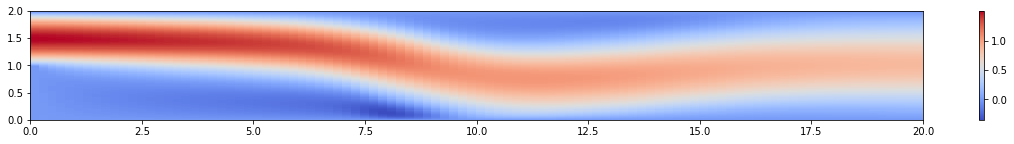

In [14]:
# X, Y = np.meshgrid(x_grid, y_grid, indexing='ij')
plt.figure(figsize=[20,2])
plt.pcolormesh(x_grid,y_grid,u_np1,cmap="coolwarm")
plt.colorbar()

In [15]:
Nx,Ny

(101, 101)

In [16]:
delT

0.006666666666666667

In [17]:
def interpolate_to_Nodes(u_val,v_val):
    u_Node = np.zeros((Ny,Nx))
    v_Node = np.zeros_like(u_Node)
    
    for i in range(0,Nx-1):
        for j in range(1,Ny-1):
            u_Node[j,i] = 0.5*(u_val[j,i]+u_val[j-1,i])
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            v_Node[j,i] = 0.5*(v_val[j,i]+v_val[j,i-1])
    
    #right boundary value based on fully developed flow assumption
    u_Node[:,-1] = u_Node[:,-2]
    v_Node[:,-1] = v_Node[:,-2]
    
    return u_Node, v_Node
    
    

In [18]:
u_node, v_node = interpolate_to_Nodes(u_np1,v_np1)

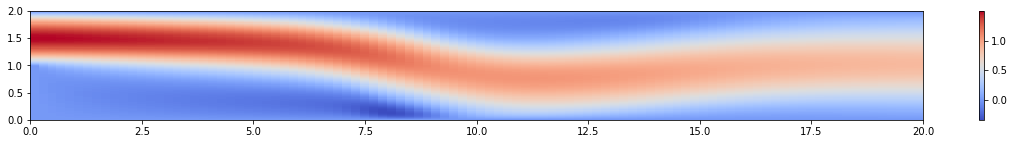

In [19]:
plt.figure(figsize=[20,2])
plt.pcolormesh(x_grid,y_grid,u_node,cmap="coolwarm")
plt.colorbar()

In [20]:

z_grid = np.array([0.0, 0.1])
u_vtk = np.zeros((Nx, Ny, 2))  # VTK ordering (x,y,z)
v_vtk = np.zeros((Nx, Ny, 2))

for k in range(2):  # Both z-layers get the same 2D data
    u_vtk[:, :, k] = u_node.T # The x and y axis are transposed between numpy and paraview
    v_vtk[:, :, k] = v_node.T


evtk.hl.gridToVTK("./strict_conv",x=x_grid,y=y_grid,z=np.zeros(1),pointData={"Ux":u_vtk,"Uy":v_vtk})


'E:\\TAMU\\Spring_25\\MEEN_644\\Homeworks\\Finals\\strict_conv.vtr'

In [57]:
Nx,Ny

(101, 101)